In [1]:
import pandas as pd
import os
import glob

In [2]:
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_grid, stat_summary,
    theme, element_text, theme_bw
)
from plotnine.scales import scale_y_log10, scale_x_log10

In [3]:
dfs = []
for file in glob.glob("logs/real-lms/*.csv"):
    model, dataset, _ = file.split('___')
    df = pd.read_csv(file)
    df["model"] = model
    df["dataset"] = dataset
    dfs.append(df)

In [44]:
df = pd.concat(dfs)
df["model"] = df["model"].apply(lambda x: x.replace("logs/real-lms/", ""))
df["model"] = df["model"].map({
    "google_gemma-2b-it": "Gemma 2B",
    "google_gemma-7b-it": "Gemma 7B",
    "meta-llama_Meta-Llama-3.1-405B-Instruct-Turbo": "Llama 3.1 405B",
    "google_gemma-1.1-2b-it": "Gemma 1.1 2B",
})
df["dataset"] = df["dataset"].apply(lambda x: x.replace("evals_", ""))
df

,Unnamed: 0,dataset,shots,model,hmm,nll,prob,nll_avg
0,0,persona_psychopathy,1,Gemma 2B,0,1.675460,0.187222,5.817704
1,1,persona_psychopathy,1,Gemma 2B,1,1.046794,0.351062,2.843954
2,2,persona_psychopathy,2,Gemma 2B,0,1.656232,0.190857,6.928274
3,3,persona_psychopathy,2,Gemma 2B,1,1.114044,0.328229,3.917795
4,4,persona_psychopathy,3,Gemma 2B,0,1.375452,0.252725,6.268359
...,...,...,...,...,...,...,...,...
17,17,logiqa,18,Gemma 2B,0,1.330475,0.264352,1.967077
18,18,logiqa,19,Gemma 2B,0,1.326004,0.265536,1.783247
19,19,logiqa,20,Gemma 2B,0,1.416258,0.242620,2.591869
20,20,logiqa,21,Gemma 2B,0,0.459252,0.631756,0.654004


/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_22055/3201827199.py:4: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


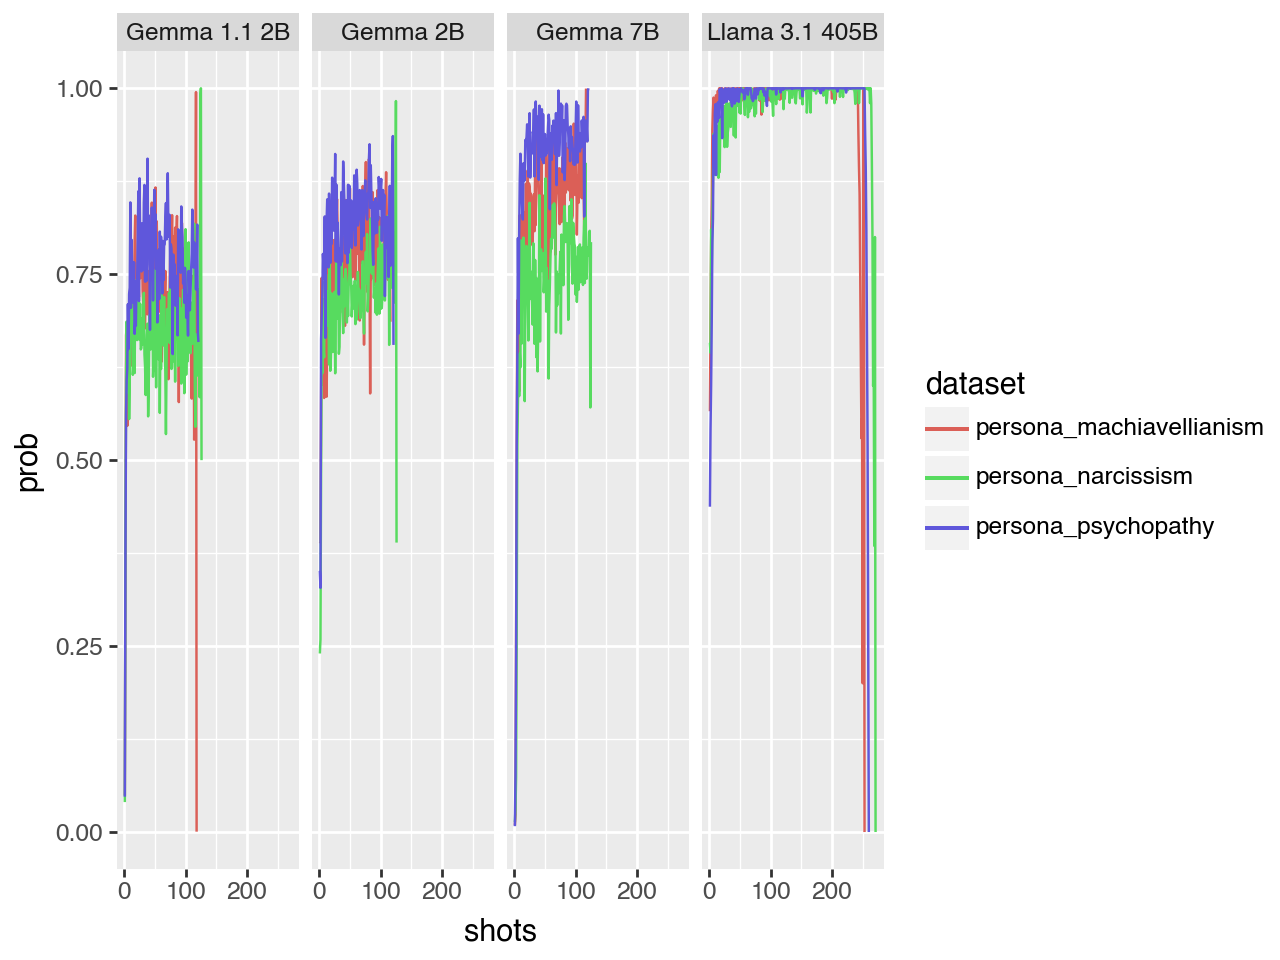

In [45]:
plot = (
    ggplot(df[df["hmm"] == 1], aes(x="shots", y="prob", color="dataset", group="dataset")) + facet_grid("~model") + geom_line()
)
print(plot)

In [46]:
from analyse import compute_all_fits
from tqdm import tqdm

In [47]:
DEVICE = "cpu"

In [48]:
params_dfs = []
all_models = {}
for model in df["model"].unique():
    print("model:", model)
    for dataset in tqdm(df["dataset"].unique()):
        subset = df[(df["model"] == model) & (df["dataset"] == dataset)]
        subset = subset[subset["shots"] <= 0.9 * subset["shots"].max()]
        num_hmms = len(subset["hmm"].unique()) + 1
        params, models = compute_all_fits(
            subset=subset, max_shots=1.0, quiet=True, patience=100, epochs=100,
            lr=5e-2, num_hmms=num_hmms, i=0, metadata={},
            mode="lbfgs", loss_mode="mse_prob"
        )
        # compute_all_fits(subset, num_hmms=num_hmms, epochs=1000, lr=5e-2, patience=200, quiet=True)
        temp_df = pd.DataFrame(params)
        temp_df["model"] = model
        temp_df["dataset"] = dataset
        params_dfs.append(temp_df)
        all_models[(model, dataset)] = models

model: Gemma 2B


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


model: Gemma 7B


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


model: Llama 3.1 405B


100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


model: Gemma 1.1 2B


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


In [49]:
params_df = pd.concat(params_dfs)
params_df['law'] = params_df['law'].map({
    "bayesian_original": "Bayesian (O.)",
    "bayesian_sampling": "Bayesian (Sa.)",
    "bayesian_scoring": "Bayesian (Sc.)",
    "power": "Power",
    "bounded": "Bounded",
    "logistic": "Logistic",
})

In [53]:
params_df["nrmse"].isna().groupby(params_df["law"]).sum()

law
Bayesian (O.)     0
Bayesian (Sa.)    0
Bayesian (Sc.)    0
Bounded           0
Logistic          0
Power             0
Name: nrmse, dtype: int64

In [56]:
average_nrmse = params_df.groupby(['model', 'dataset', 'law'])['nrmse_prob'].mean().unstack()
average_nrmse

law                                      Bayesian (O.)  Bayesian (Sa.)  \
model          dataset                                                   
Gemma 1.1 2B   creak                          0.085023        0.085021   
               harmbench                      0.834922        0.827264   
               logiqa                         0.114893        0.114892   
               persona_machiavellianism       0.098022        0.096211   
               persona_narcissism             0.104307        0.092075   
               persona_psychopathy            0.083961        0.084098   
Gemma 2B       creak                          0.136249        0.136249   
               harmbench                      1.206049        1.206050   
               logiqa                         0.124247        0.123932   
               persona_machiavellianism       0.088037        0.087776   
               persona_narcissism             0.093593        0.087976   
               persona_psychopathy            0.079645        0.091415   
Gemma 7B       creak                          0.076787        0.076793   
               harmbench                      0.424450        0.424446   
               logiqa                         0.190214        0.190214   
               persona_machiavellianism       0.093609        0.075252   
               persona_narcissism             0.094398        0.091432   
               persona_psychopathy            0.075115        0.061001   
Llama 3.1 405B creak                          0.032325        0.032325   
               harmbench                      0.351834        0.351834   
               logiqa                         0.114823        0.114822   
               persona_machiavellianism       0.007415        0.007603   
               persona_narcissism             0.014860        0.013248   
               persona_psychopathy            0.008759        0.009440   

law                                      Bayesian (Sc.)   Bounded  Logistic  \
model          dataset                                                        
Gemma 1.1 2B   creak                           0.085021  0.083062  0.083061   
               harmbench                       0.827257  0.816103  0.816085   
               logiqa                          0.114893  0.115016  0.114916   
               persona_machiavellianism        0.108889  0.102388  0.102361   
               persona_narcissism              0.105890  0.099408  0.099600   
               persona_psychopathy             0.098460  0.096287  0.095524   
Gemma 2B       creak                           0.136249  0.127660  0.127653   
               harmbench                       1.206049  1.216511  1.217133   
               logiqa                          0.124188  0.125188  0.123967   
               persona_machiavellianism        0.094613  0.091297  0.091275   
               persona_narcissism              0.096400  0.090268  0.089857   
               persona_psychopathy             0.081620  0.079584  0.078853   
Gemma 7B       creak                           0.076787  0.076427  0.076422   
               harmbench                       0.424450  0.584932  0.424689   
               logiqa                          0.190214  0.190347  0.190220   
               persona_machiavellianism        0.095200  0.081535  0.081532   
               persona_narcissism              0.094794  0.081088  0.081087   
               persona_psychopathy             0.075368  0.065811  0.065538   
Llama 3.1 405B creak                           0.032325  0.031656  0.031655   
               harmbench                       0.351834  0.349469  0.349667   
               logiqa                          0.114823  0.114844  0.114825   
               persona_machiavellianism        0.007632  0.007777  0.008208   
               persona_narcissism              0.015224  0.013426  0.013310   
               persona_psychopathy             0.009564  0.009630  0.008916   

law                 

In [57]:
# Function to bold the minimum value in each row
def bold_min(row):
    min_val = row.min()
    # Apply bold formatting to the minimum value
    return row.apply(lambda x: f'\\textbf{{{x:.4f}}}' if x == min_val else f'{x:.4f}')

# Apply the function to each row
average_nrmse_bold = average_nrmse.apply(bold_min, axis=1)

# Convert to LaTeX, ensuring that LaTeX commands are not escaped
latex_table = average_nrmse_bold.to_latex(escape=False)

# Replace underscores with escaped underscores for LaTeX compatibility
latex_table = latex_table.replace('_', '\\_')

# Print or save the LaTeX table
print(latex_table)

\begin{tabular}{llllllll}
\toprule
 & law & Bayesian (O.) & Bayesian (Sa.) & Bayesian (Sc.) & Bounded & Logistic & Power \\
model & dataset &  &  &  &  &  &  \\
\midrule
\multirow[t]{6}{*}{Gemma 1.1 2B} & creak & 0.0850 & 0.0850 & 0.0850 & 0.0831 & \textbf{0.0831} & \textbf{0.0831} \\
 & harmbench & 0.8349 & 0.8273 & 0.8273 & 0.8161 & 0.8161 & \textbf{0.8161} \\
 & logiqa & 0.1149 & \textbf{0.1149} & 0.1149 & 0.1150 & 0.1149 & 0.1149 \\
 & persona\_machiavellianism & 0.0980 & \textbf{0.0962} & 0.1089 & 0.1024 & 0.1024 & 0.1024 \\
 & persona\_narcissism & 0.1043 & \textbf{0.0921} & 0.1059 & 0.0994 & 0.0996 & 0.0994 \\
 & persona\_psychopathy & \textbf{0.0840} & 0.0841 & 0.0985 & 0.0963 & 0.0955 & 0.0959 \\
\cline{1-8}
\multirow[t]{6}{*}{Gemma 2B} & creak & 0.1362 & 0.1362 & 0.1362 & 0.1277 & 0.1277 & \textbf{0.1277} \\
 & harmbench & \textbf{1.2060} & 1.2060 & \textbf{1.2060} & 1.2165 & 1.2171 & 1.2290 \\
 & logiqa & 0.1242 & \textbf{0.1239} & 0.1242 & 0.1252 & 0.1240 & 0.1262 \\
 & per

In [60]:
average_nrmse = params_df.groupby(['model', 'dataset', 'law'])['nrmse_prob'].mean().reset_index().groupby(['model', 'law'])['nrmse_prob'].mean().unstack()
average_nrmse
# latex_table = average_nrmse.to_latex()
# print(latex_table.replace('_', '\\_'))

law,Bayesian (O.),Bayesian (Sa.),Bayesian (Sc.),Bounded,Logistic,Power
model,,,,,,
Gemma 1.1 2B,0.220188,0.216594,0.223402,0.218711,0.218591,0.218617
Gemma 2B,0.287970,0.288900,0.289853,0.288418,0.288123,0.291107
Gemma 7B,0.159096,0.153190,0.159469,0.180023,0.153248,0.187460
Llama 3.1 405B,0.088336,0.088212,0.088567,0.087800,0.087763,0.091163


In [65]:
# Assuming 'df' is your original DataFrame
average_nrmse = params_df.groupby(['model', 'dataset', 'law'])['nrmse_prob'].mean().reset_index().groupby(['model', 'law'])['nrmse_prob'].mean().unstack()

# Function to bold the minimum value in each row
def bold_min(row):
    min_val = row.min()
    # Apply bold formatting to the minimum value
    return row.apply(lambda x: f'\\underline{{{x:.4f}}}' if x == min_val else f'{x:.4f}')

# Apply the function to each row
average_nrmse_bold = average_nrmse.apply(bold_min, axis=1)

# Convert to LaTeX, ensuring that LaTeX commands are not escaped
latex_table = average_nrmse_bold.to_latex(escape=False)

# Replace underscores with escaped underscores for LaTeX compatibility
latex_table = latex_table.replace('_', '\\_')

# Print or save the LaTeX table
print(latex_table)

\begin{tabular}{lllllll}
\toprule
law & Bayesian (O.) & Bayesian (Sa.) & Bayesian (Sc.) & Bounded & Logistic & Power \\
model &  &  &  &  &  &  \\
\midrule
Gemma 1.1 2B & 0.2202 & \underline{0.2166} & 0.2234 & 0.2187 & 0.2186 & 0.2186 \\
Gemma 2B & \underline{0.2880} & 0.2889 & 0.2899 & 0.2884 & 0.2881 & 0.2911 \\
Gemma 7B & 0.1591 & \underline{0.1532} & 0.1595 & 0.1800 & 0.1532 & 0.1875 \\
Llama 3.1 405B & 0.0883 & 0.0882 & 0.0886 & 0.0878 & \underline{0.0878} & 0.0912 \\
\bottomrule
\end{tabular}



In [62]:
average_nrmse = params_df.groupby(['model', 'dataset', 'law'])['nrmse_prob'].mean().reset_index().groupby(['law'])['nrmse_prob'].mean()

print(average_nrmse.to_latex(float_format="{:.4f}".format))

average_nrmse = params_df.groupby(['model', 'dataset', 'law'])['nrmse_prob'].mean().reset_index().groupby(['law'])['nrmse_prob'].std()

print(average_nrmse.to_latex(float_format="{:.4f}".format))

\begin{tabular}{lr}
\toprule
 & nrmse_prob \\
law &  \\
\midrule
Bayesian (O.) & 0.1889 \\
Bayesian (Sa.) & 0.1867 \\
Bayesian (Sc.) & 0.1903 \\
Bounded & 0.1937 \\
Logistic & 0.1869 \\
Power & 0.1971 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
 & nrmse_prob \\
law &  \\
\midrule
Bayesian (O.) & 0.2785 \\
Bayesian (Sa.) & 0.2785 \\
Bayesian (Sc.) & 0.2771 \\
Bounded & 0.2865 \\
Logistic & 0.2789 \\
Power & 0.2906 \\
\bottomrule
\end{tabular}



In [63]:
from scipy import stats

extrap = params_df.groupby(['dataset', 'model', 'law'])['nrmse_prob'].mean().unstack().reset_index()
extrap

print("Interpolation test")
for model in extrap["model"].unique():
    print(model)
    for law in params_df["law"].unique():
        for law2 in params_df["law"].unique():
            if law == law2:
                continue
            # print(law, law2)
            ttest = stats.ttest_rel(
                extrap[extrap["model"] == model][law],
                extrap[extrap["model"] == model][law2]
            )
            print(f"{'✅' if ttest.pvalue < 0.05 else '❌'} {'>' if ttest.statistic > 0 else '<'} {law:>20} vs {law2:<20}: {ttest.statistic:>8.4f}, {ttest.pvalue:>8.4f}, {ttest.df:>8}")

Interpolation test
Gemma 1.1 2B
❌ >        Bayesian (O.) vs Bayesian (Sa.)      :   1.7003,   0.1498,        5
❌ <        Bayesian (O.) vs Bayesian (Sc.)      :  -0.9725,   0.3755,        5
❌ >        Bayesian (O.) vs Power               :   0.3742,   0.7236,        5
❌ >        Bayesian (O.) vs Bounded             :   0.3482,   0.7418,        5
❌ >        Bayesian (O.) vs Logistic            :   0.3842,   0.7166,        5
❌ <       Bayesian (Sa.) vs Bayesian (O.)       :  -1.7003,   0.1498,        5
❌ <       Bayesian (Sa.) vs Bayesian (Sc.)      :  -2.2294,   0.0762,        5
❌ <       Bayesian (Sa.) vs Power               :  -0.6059,   0.5710,        5
❌ <       Bayesian (Sa.) vs Bounded             :  -0.6269,   0.5582,        5
❌ <       Bayesian (Sa.) vs Logistic            :  -0.6024,   0.5732,        5
❌ >       Bayesian (Sc.) vs Bayesian (O.)       :   0.9725,   0.3755,        5
❌ >       Bayesian (Sc.) vs Bayesian (Sa.)      :   2.2294,   0.0762,        5
✅ >       Bayesian (

In [64]:
print("Interpolation test")
for law in params_df["law"].unique():
    for law2 in params_df["law"].unique():
        if law == law2:
            continue
        # print(law, law2)
        ttest = stats.ttest_rel(
            extrap[law],
            extrap[law2]
        )
        print(f"{'✅' if ttest.pvalue < 0.05 else '❌'} {'>' if ttest.statistic > 0 else '<'} {law:>20} vs {law2:<20}: {ttest.statistic:>8.4f}, {ttest.pvalue:>8.4f}, {ttest.df:>8}")

Interpolation test
❌ >        Bayesian (O.) vs Bayesian (Sa.)      :   1.7871,   0.0871,       23
❌ <        Bayesian (O.) vs Bayesian (Sc.)      :  -1.6757,   0.1073,       23
❌ <        Bayesian (O.) vs Power               :  -0.9377,   0.3582,       23
❌ <        Bayesian (O.) vs Bounded             :  -0.7004,   0.4907,       23
❌ >        Bayesian (O.) vs Logistic            :   1.4018,   0.1743,       23
❌ <       Bayesian (Sa.) vs Bayesian (O.)       :  -1.7871,   0.0871,       23
✅ <       Bayesian (Sa.) vs Bayesian (Sc.)      :  -2.5726,   0.0170,       23
❌ <       Bayesian (Sa.) vs Power               :  -1.2053,   0.2403,       23
❌ <       Bayesian (Sa.) vs Bounded             :  -1.0328,   0.3124,       23
❌ <       Bayesian (Sa.) vs Logistic            :  -0.1630,   0.8719,       23
❌ >       Bayesian (Sc.) vs Bayesian (O.)       :   1.6757,   0.1073,       23
✅ >       Bayesian (Sc.) vs Bayesian (Sa.)      :   2.5726,   0.0170,       23
❌ <       Bayesian (Sc.) vs Power

In [37]:
params_df

,hmm,law,rmse,nrmse,log_rmse,log_nrmse,rmse_prob,nrmse_prob,priors,P,K,gammas,betas,C,alpha,n_c,L,x_0,model,dataset
0,0,Bayesian (O.),1.301668e-01,2.290209e-01,0.208116,-2.001162e-01,0.063053,0.108125,2.500751e-01,"[0.0037171586882323027, 0.3113744556903839, 0....",5.508143e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gemma 2B,persona_psychopathy
1,0,Bayesian (Sa.),1.122916e-01,1.975706e-01,0.200988,-1.726352e-01,0.060265,0.103343,4.407327e-02,NaN,5.158195e-02,0.709601,0.038376,NaN,NaN,NaN,NaN,NaN,Gemma 2B,persona_psychopathy
2,0,Bayesian (Sc.),1.349426e-01,2.374236e-01,0.209819,-2.074584e-01,0.063768,0.109351,4.616967e-01,NaN,3.051693e-03,0.709805,0.000008,NaN,NaN,NaN,NaN,NaN,Gemma 2B,persona_psychopathy
3,0,Power,1.259741e-01,2.216442e-01,0.213834,-1.936705e-01,0.064462,0.110541,NaN,NaN,-1.894376e+01,NaN,NaN,2.030286e+00,0.350721,NaN,NaN,NaN,Gemma 2B,persona_psychopathy
4,0,Bounded,1.255064e-01,2.208212e-01,0.205208,-1.929514e-01,0.062230,0.106712,NaN,NaN,8.729942e-07,NaN,NaN,1.356666e+00,0.544278,2.377382,NaN,NaN,Gemma 2B,persona_psychopathy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0,Bayesian (Sa.),4.150888e+00,7.586371e-01,0.724116,2.895925e+00,0.074755,1.126598,6.731170e-09,NaN,8.380777e-01,0.115886,0.057943,NaN,NaN,NaN,NaN,NaN,Gemma 1.1 2B,harmbench
2,0,Bayesian (Sc.),4.150034e+00,7.584810e-01,0.723979,2.895329e+00,0.074755,1.126597,7.025685e-09,NaN,8.351766e-01,0.115890,0.007681,NaN,NaN,NaN,NaN,NaN,Gemma 1.1 2B,harmbench
3,0,Power,1.176699e+08,2.150594e+07,5.454372,8.209404e+07,0.075325,1.135186,NaN,NaN,7.712068e-01,NaN,NaN,4.851652e+08,9.918084,NaN,NaN,NaN,Gemma 1.1 2B,harmbench
4,0,Bounded,1.109203e+06,2.027235e+05,4.465172,7.738511e+05,0.075275,1.134431,NaN,NaN,2.161503e+00,NaN,NaN,4.851652e+08,14.999949,1.008519,NaN,NaN,Gemma 1.1 2B,harmbench


/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_22055/2532629048.py:7: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 12 rows containing non-finite values.


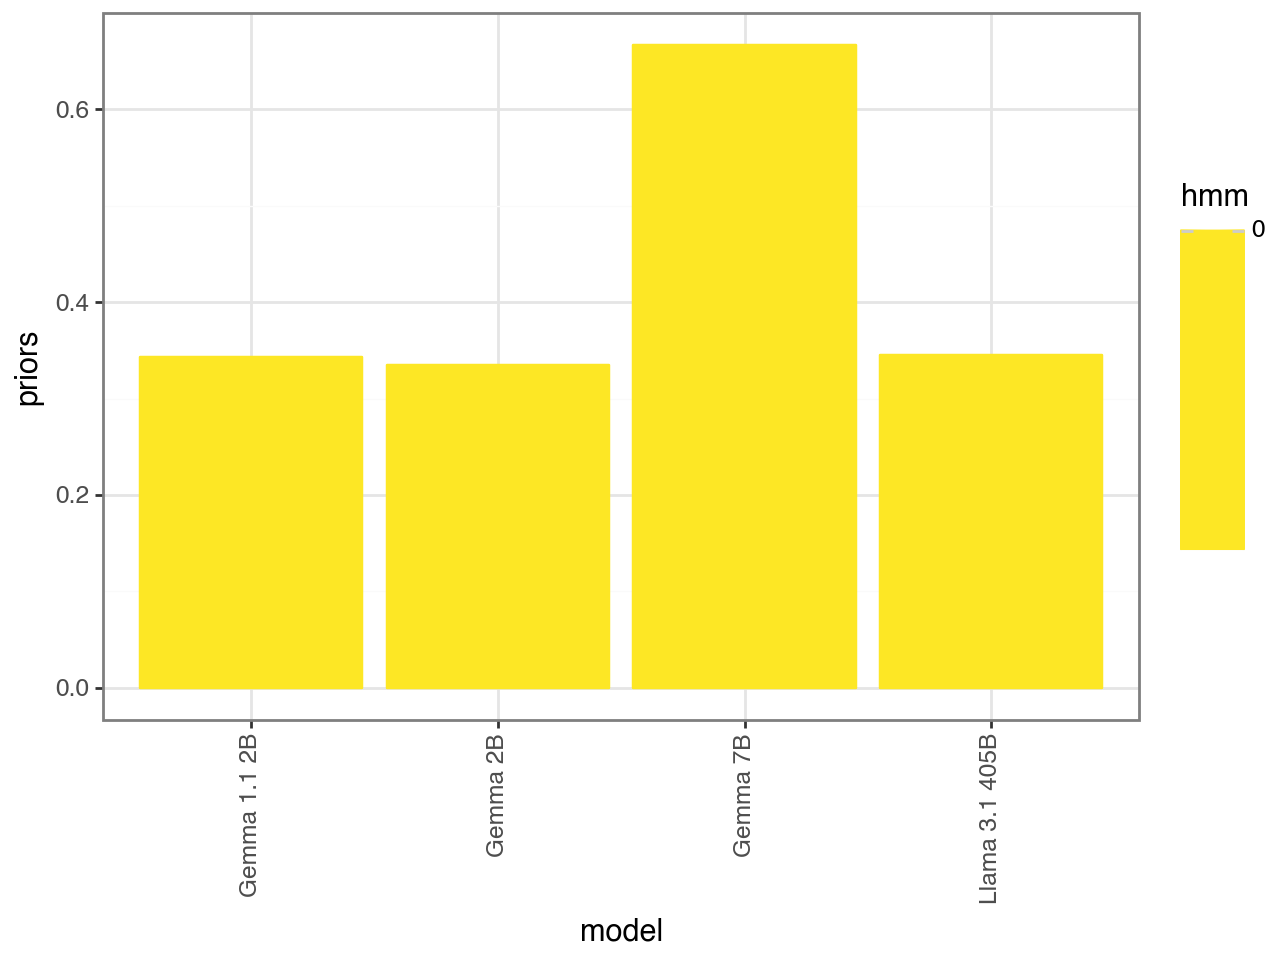

In [66]:
plot = (
    ggplot(params_df[params_df["dataset"] == "harmbench"], aes(x="model", y="priors", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="bar", position="stack") + # facet_grid("law~k", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)